# 1.0 Introduction

# 2.0 Requirements and Imports

## 2.1 Requirements

## 2.2 Imports

In [33]:
import os
import re
import bs4
import time
import requests
import pandas as pd
import numpy as np
from os import listdir
from datetime import date
from bs4 import BeautifulSoup  
from os.path import isfile, join

# --- selenium libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service

# language detector
from langdetect import detect
from langdetect import detect_langs

# Wordcloud visualization
import seaborn as sns
import itertools
import collections
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# nltk
import nltk
import nltk.corpus
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk, Tree
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

# seaborn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Handle warnings
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\efi13\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\efi13\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 3.0 Data Acquision


## 3.1 Resources


### 3.1.1 Medium


In [ ]:
#chromedriver.exe for windows users!

In [ ]:
def get_infinity_page_html_data(chromedriver_path="./chromedriver.exe", scroll_number=1, sleep_time=3):
    # Create selenium driver
    s = Service(chromedriver_path)
    driver = webdriver.Chrome(service=s)    
    driver.get(url)
    
    for i in range(1,scroll_number):
        print(f"scroll_number: {i}")
        driver.execute_script("window.scrollTo(1,50000)")
        time.sleep(sleep_time)
    html_data = driver.page_source
    driver.close()
    
    return html_data

In [ ]:
def extract_medium_articles_from_HTML_data(html_data):
    # Extract articles from HTML data 
    soup = BeautifulSoup(html_data, 'html.parser')    
    articles = soup.find_all("article")
    print(f"Number of articles: {len(articles)}")
    
    return articles

In [ ]:
def create_df_from_articles(articles,category):    
    # Create a lists for df
    categories = []
    headers = []
    contents = []
    for article in articles:
        headers.append(article.find("h2").get_text()) 
        categories.append(category)
        
        if category == "politics" or category == "food":
            content = article.find("p", {"class": lambda L: L and L.startswith('lj b do dp')})        
        if category == "sports" or category == "technology" or category == "weather":
            content = article.find("p", {"class": lambda L: L and L.startswith('lf b do dp')})
        if category == "entertainment":
            content = article.find("p", {"class": lambda L: L and L.startswith('lg b do dp')})
        if category == "business" or category == "science":
            content = article.find("p", {"class": lambda L: L and L.startswith('li b do dp')})
        
        if content is not None:
            contents.append(content.get_text())
        else:
            contents.append(content)        
        
    return pd.DataFrame(
        {"category": categories,  
         "header": headers,
         "content": contents})

In [ ]:
#here you can add more categories
#sports, technology, politics, entertiment, business, weather, food, science ... 
categories = ["technology", "politics", "sports", "entertainment", "weather", "science", "business", "food"]

for category in categories:     
    url = f"https://medium.com/tag/{category}"
    html_data = get_infinity_page_html_data(scroll_number=10)
    articles = extract_medium_articles_from_HTML_data(html_data)
    df = create_df_from_articles(articles, category)
    print(df.shape)
    
    df.to_csv(f"./csv_files/medium_{category}_{date.today()}.csv") 

### 3.1.2 Hubpages

In [ ]:
def get_page_html_data_with_see_more_option(url, chromedriver_path="./chromedriver.exe", numbers_of_see_more_clicks=1, sleep_time=3):
    # Create selenium driver
    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service)    
    driver.get(url)
    driver.maximize_window()

    for i in range(1,numbers_of_see_more_clicks+1):                
        button_xpath = "//button[@class='m-footer-loader--button m-component-footer--loader m-button']"                
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_time)
        print(f"Numbers of clicks: {i}")
        driver.find_element(by=By.XPATH, value=button_xpath).click()                    
        time.sleep(sleep_time)
        
    html_data = driver.page_source
    driver.close()
    
    return html_data

In [ ]:
def extract_hubpages_articles_from_HTML_data(html_data):        
    # Extract articles from HTML data 
    soup = BeautifulSoup(html_data, 'html.parser')    
    articles = soup.find_all("div", {"class": "m-card--content"})          
    
    return articles

In [ ]:
def create_df_from_articles(articles, category):    
    # Create a lists for df
    categories = []
    headers = []
    contents= []

    for article in articles:
        categories.append(category)
        headers.append(article.find("h2").get_text())
        content = article.find("p", {"class": "m-card--body m-ellipsis--text"})
        if content is not None:
            contents.append(content.get_text())            
        else:
            contents.append(content)                
        
    return pd.DataFrame(
        {"category": categories,  
         "header": headers, 
         "contents": contents})

In [ ]:
# "science", "weather" - doesnt exists
categories = ["politics", "sports", "food", "entertainment", "business", "technology"]
categories = ["entertainment", "business", "technology"]
for category in categories: 
    url = f"https://discover.hubpages.com/{category}/"
    html_data = get_page_html_data_with_see_more_option(url, numbers_of_see_more_clicks=10)
    articles = extract_hubpages_articles_from_HTML_data(html_data)
    df = create_df_from_articles(articles, category)    
    df.to_csv(f"./csv_files/hubpages_{category}_{date.today()}.csv")
    print(df.shape)    

### 3.1.3 Newsbreak

In [ ]:
def get_infinity_page_html_data(chromedriver_path="./chromedriver.exe", scroll_number=1, sleep_time=3):
    # Create selenium driver
    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service)    
    driver.get(url)
    
    for i in range(1,scroll_number+1):
        print(f"scroll_number: {i}")
        driver.execute_script("window.scrollTo(1,50000)")
        time.sleep(sleep_time)
    html_data = driver.page_source
    driver.close()
    
    return html_data

In [ ]:
def extract_newsbreak_articles_from_HTML_data(html_data):
    # Extract articles from HTML data 
    soup = BeautifulSoup(html_data, 'html.parser')    
    articles = soup.find_all("article")
    print(f"Number of articles: {len(articles)}")        
    
    return articles

In [ ]:
def create_df_from_articles(articles,category):    
    # Create a lists for df
    categories = []
    headers = []
    contents= []
        
    for article in articles:            
        categories.append(category)        
        headers.append(article.find("a", {"class": lambda L: L and L.startswith('ContentCardBody_title')}).get_text())                           
        contents.append(article.find("div", {"class": lambda L: L and L.startswith('ContentCardBody_summary')}).get_text())    
    
    return pd.DataFrame(
        {"categories": categories,  
         "headers": headers, 
         "contents": contents})

In [ ]:
# "food" - doesnt exists
categories = ["technology","politics", "sports", "science", "entertainment", "business", 'weather']
for category in categories: 
    url = f"https://www.newsbreak.com/channels/{category}"    
    html_data = get_infinity_page_html_data(scroll_number=10)
    articles = extract_newsbreak_articles_from_HTML_data(html_data)
    df = create_df_from_articles(articles,category)
    df.to_csv(f"./csv_files/newsbreak_{category}_{date.today()}.csv")
    print(df.shape)
    print()

### 3.1.4 Weather.com

In [ ]:
def extract_articles_HTML(url):
    request = requests.get(url)
    return BeautifulSoup(request.content, 'html.parser')
    

In [ ]:
def create_weather_news_df(url,page):
    header = []
    content = []
    category = []
    for i in range(page,page+1):
        time.sleep(3)
        try:
            url = url+f"{i}"
            soup = extract_articles_HTML(url)


            main_content = soup.find("div",{"id":lambda L: L and L.startswith('WxuCollectionMediaList-main')})
            li_lst = main_content.find_all("li")
            print(f"page number: {i}")            
            for li in li_lst:
                header.append(li.find("div",
                                       {"class":lambda L: L and L.startswith('CollectionMediaList--title')}).get_text())
                content.append(li.find("div",
                                       {"class":lambda L: L and L.startswith('CollectionMediaList--caption')}).get_text())
                category.append("weather")
            
        except:
            print(f"error in page {i}")
    return pd.DataFrame({"category":category, "header":header, "content":content})


In [ ]:
df = create_weather_news_df('https://weather.com/news?pg=',1)
for i in range(2,201):
    df = df.append(create_weather_news_df('https://weather.com/news?pg=',i))
    time.sleep(4)
    print(df.shape)
df.to_csv(f"./csv_files/weather_com_{date.today()}.csv")

### 3.1.5 ScienceNews

In [ ]:
def create_science_news_df(url,page):
    header = []
    content = []
    category = []

    for i in range (page,page+1):
        time.sleep(3)
        try:
            print(f"page number: {i}")
            url = url + f'{i}'
            soup = extract_articles_HTML(url)

            main_content = soup.find_all("ol")[0]
            li_lst = main_content.find_all("li")

            for li in li_lst:
                category.append("science")
                header.append(li.find("h3").get_text().strip())
                content.append(li.find("p").get_text().strip())


        except:
            print(f"error in page {i}")


    return pd.DataFrame({"category":category, "header":header, "content":content})

In [ ]:
df = create_science_news_df('https://www.sciencenews.org/topic/science-society/page/',1)
for i in range(2,81):
    df = df.append(create_science_news_df('https://www.sciencenews.org/topic/science-society/page/',i))
    time.sleep(4)
    print(df.shape)

In [ ]:
df.to_csv(f"./csv_files/science_news_{date.today()}.csv")

### 3.1.5 Food52

In [ ]:
def create_food_news_df(url,page):
    header = []
    content = []
    category = []

    for i in range (page,page+1):
        time.sleep(3)
        try:
            print(f"page number: {i}")
            url = url + f'{i}'
            soup = extract_articles_HTML(url)

            content_lst = soup.find_all("div",{"class":"tag-post__body"})
            for item in content_lst:
                category.append("food")
                header.append(item.find("h3").get_text().strip())
                content.append(item.find("p").get_text().strip())

        except:
            print(f"error in page {i}")


    return pd.DataFrame({"category":category, "header":header, "content":content})

In [ ]:
df = create_food_news_df('https://food52.com/tags/food-news?page=',1)
for i in range(2,45):
    df = df.append(create_food_news_df('https://food52.com/tags/food-news?page=',i))
    time.sleep(4)
    print(df.shape)

In [ ]:
df.to_csv(f"./csv_files/food52_news_{date.today()}.csv")

## 3.2 Data Acquision Results


In [4]:
#create a list of all file names
file_names_list = [f for f in listdir('./csv_files/') if isfile(join('./csv_files/', f))]

In [5]:
temp_df = pd.read_csv(f'./csv_files/{file_names_list[0]}')
temp_df.columns = ['Unnamed: 0', 'category', 'header', 'content']
merged_df = temp_df.copy()
print("before:",merged_df.shape)

for i in range(1,len(file_names_list)):
    temp_df = pd.read_csv(f'./csv_files/{file_names_list[i]}')
    #change in each df to the same column names
    temp_df.columns = ['Unnamed: 0', 'category', 'header', 'content']
    merged_df = merged_df.append(temp_df)
    
print("after:",merged_df.shape)    

before: (612, 4)
after: (31607, 4)


In [7]:
merged_df.to_csv('merged_csv.csv')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31607 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31607 non-null  int64 
 1   category    31607 non-null  object
 2   header      31607 non-null  object
 3   content     26464 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


# 4.0 Data Cleaning


In this notebook we present our research about our data.  
There are two types of cells:
1. A cell that presents research and insights about the data information.
2. A cell that changes the `df` according to the specific insight.

In [8]:
df = pd.read_csv("./merged_csv.csv")

## 4.1 Remove Unnecessary Columns


In [9]:
print(df.shape)
df.head()

(31607, 5)


,Unnamed: 0,Unnamed: 0.1,category,header,content
0,0,0,food,"161,692 Pounds of Skippy Peanut Butter Have Be...",Three kinds of peanut butter have been recalle...
1,1,1,food,Impossible Foods Sausage Links Are the Plant-B...,The impossible is now possible!
2,2,2,food,"Goodbye to Chowhound, the Internet’s First Foo...",This 25-year-old corner of the culinary intern...
3,3,3,food,"Thank You, Mr. Entenmann, for the Nicest Cake ...",Charles Entenmann was the center of our daily ...
4,4,4,food,How Home Cooks Are Supporting Ukrainians Right...,"Around the world, home cooks are using bake sa..."


In the df above we have two unnecessary columns:

Unnamed: 0
Unnamed: 0.1 Let's drop these two columns.

In [10]:
# Romove df columns
df.drop(columns="Unnamed: 0", axis=1, inplace=True)
df.drop(columns="Unnamed: 0.1", axis=1, inplace=True)

In [11]:
df

,category,header,content
0,food,"161,692 Pounds of Skippy Peanut Butter Have Be...",Three kinds of peanut butter have been recalle...
1,food,Impossible Foods Sausage Links Are the Plant-B...,The impossible is now possible!
2,food,"Goodbye to Chowhound, the Internet’s First Foo...",This 25-year-old corner of the culinary intern...
3,food,"Thank You, Mr. Entenmann, for the Nicest Cake ...",Charles Entenmann was the center of our daily ...
4,food,How Home Cooks Are Supporting Ukrainians Right...,"Around the world, home cooks are using bake sa..."
...,...,...,...
31602,weather,"Colorado Avalanches Bury Cars, Roadways; Backc...",Avalanches closed highways and buried cars thi...
31603,weather,Alabama Gov. Kay Ivey Views EF4 Tornado Damage...,The Alabama town of Beauregard continues to re...
31604,weather,Alabama Tornado Victims: Funerals Begin for th...,Four children are among the 23 people who died...
31605,weather,NASA Captures First Images of Intersecting Sho...,"Using advanced photographic technology, NASA h..."


## 4.2 Remove Null Objects


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31607 entries, 0 to 31606
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  31607 non-null  object
 1   header    31607 non-null  object
 2   content   26464 non-null  object
dtypes: object(3)
memory usage: 740.9+ KB


In [13]:
df[df['content'].isna()]

,category,header,content
623,business,More Than 70% of People Have Imposter Syndrome...,NaN
625,business,4 investments that may be profitable in the fu...,NaN
633,business,How To Flip a Coin Successfully,NaN
636,business,Ecommerce Website Design Tips and Best Practices,NaN
646,business,What to Consider When Starting a Road Contract...,NaN
...,...,...,...
31077,weather,20 Killed by Hurricane Dorian in the Bahamas,NaN
31087,weather,Hurricane Dorian Death Toll Rises to 5,NaN
31104,weather,Lightning Strike Injures Six People at Golf To...,NaN
31381,weather,Powerful 8.0 Magnitude Earthquake Strikes Nort...,NaN


The two cell above showed us that we have `null` objects in content column.  
As a result we need to drop these `null` objects.

In [14]:
# Remove null objects
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26464 entries, 0 to 31606
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  26464 non-null  object
 1   header    26464 non-null  object
 2   content   26464 non-null  object
dtypes: object(3)
memory usage: 827.0+ KB


## 4.2 Remove Duplicate Rows


In [15]:
df[df.duplicated() == True]

,category,header,content
459,food,Weekend Reading,5 of the best things we read this week
464,food,Weekend Reading,Articles we read and loved this week
554,food,Your Monday Lunch Break Reading List,Busy weekend? Here's what you may have missed ...
575,food,8 Food Blog Links We Love,We've scoured the web for our favorite food bl...
576,food,8 Food Blog Links We Love,We've scoured the web for our favorite food bl...
...,...,...,...
31064,weather,"In the Bahamas, Official Hurricane Dorian Deat...",Here is the latest information on search and r...
31070,weather,Aid Begins to Reach Bahamas Islands Devastated...,Here is the latest information on search and r...
31178,weather,"Wildfires Rage in Oregon, Washington; 9 Firefi...",Wildfires are threatening homes in Washington ...
31193,weather,The Weather Channel Receives Two Emmy Nominations,Here are the awards for which The Weather Chan...


The cell above showed us that we have duplicate rows in our dataframe.  
As a result we need to prune these rows.

In [16]:
# Prune duplicate rows
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 0 to 31606
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  15538 non-null  object
 1   header    15538 non-null  object
 2   content   15538 non-null  object
dtypes: object(3)
memory usage: 485.6+ KB


In [75]:
clean_df = df.copy(deep=True)

# 5.0 EDA


## 5.1 Merged header and content

In [76]:
df["merged_text"] = df["header"] + " " + df["content"]
df.drop(columns="header", axis=1, inplace=True)
df.drop(columns="content", axis=1, inplace=True)
df 

,category,merged_text
0,food,"161,692 Pounds of Skippy Peanut Butter Have Be..."
1,food,Impossible Foods Sausage Links Are the Plant-B...
2,food,"Goodbye to Chowhound, the Internet’s First Foo..."
3,food,"Thank You, Mr. Entenmann, for the Nicest Cake ..."
4,food,How Home Cooks Are Supporting Ukrainians Right...
...,...,...
31602,weather,"Colorado Avalanches Bury Cars, Roadways; Backc..."
31603,weather,Alabama Gov. Kay Ivey Views EF4 Tornado Damage...
31604,weather,Alabama Tornado Victims: Funerals Begin for th...
31605,weather,NASA Captures First Images of Intersecting Sho...


## 5.2 Visualization Vol.1

### 5.2.1 Pie Chart

In [77]:
def show_pie_chart(df):
    count_of_categories_articles = df['category'].value_counts(sort=False).to_list()
    categories = df['category'].unique()


    plt.pie(count_of_categories_articles, 
            labels = categories,
            autopct = "%1.1f%%",
            explode = [0.05 for _ in categories])

    plt.show()

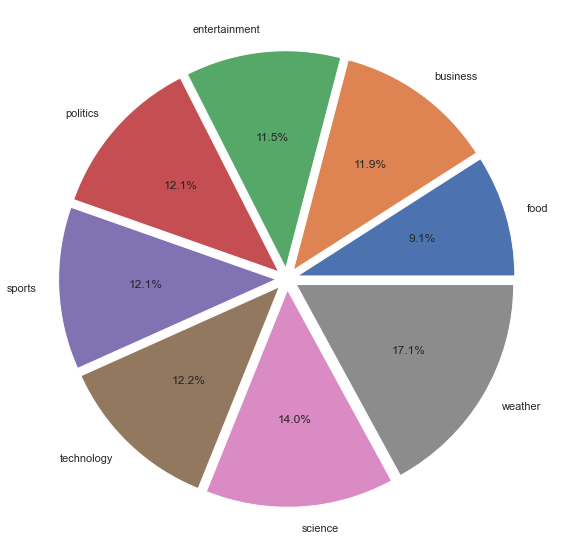

In [78]:
show_pie_chart(df)

### 5.2.2 WordCloud

In [79]:
def wordcloud_draw(dataset, mask=None, color = 'white'):
    if mask is not None:        
        mask = os.path.join(os.getcwd(), mask)
        print(mask)
        mask = np.array(Image.open(f'{mask}',mode='r'))
    
    # Before tokenize
    if isinstance(dataset.iloc[0], str):
        words = ' '.join(dataset)
        cleaned_word = ' '.join([word for word in words.split()])        
        
    # After tokeniz        
    elif isinstance(dataset.iloc[0], list):        
        words = dataset.sum()
        cleaned_word = ' '.join(words)        
        
    wordcloud = WordCloud(background_color = color,
                          mask = mask,
                          width = 2500, 
                          height = 2500,
                          contour_width=2,).generate(cleaned_word)

    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [80]:
## Vizualization word cloud
def show_word_cloud(df):
    category_series_words = {}

    for category in set(df["category"]):
        category_words = df[df["category"] == category]["merged_text"]
        category_series_words[category] = category_words

    for category, series_words in category_series_words.items():        
        wordcloud_draw(series_words, f"png\\{category}.png", 'white')

C:\Users\efi13\source\last\png\business.png


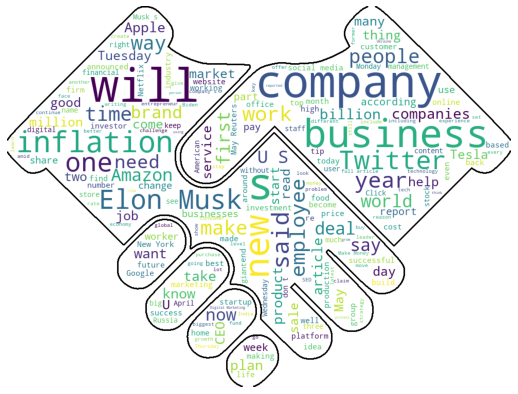

C:\Users\efi13\source\last\png\sports.png


KeyboardInterrupt: 

In [81]:
show_word_cloud(df)

### 5.2.3 Top 10 words

In [ ]:
def show_top_10_words(df):
    tmp_df = df.copy()
    if isinstance(tmp_df['merged_text'].iloc[0], str):
        tmp_df['merged_text'] = tmp_df['merged_text'].apply(word_tokenize)
        
    for category in set(tmp_df["category"]):        
        category_words = tmp_df[tmp_df["category"] == category]["merged_text"]

        filtered_words = list(itertools.chain.from_iterable(category_words))        
        counted_words = collections.Counter(filtered_words)

    
        words = []
        counts = []
        for letter, count in counted_words.most_common(10):
            words.append(letter)
            counts.append(count)

        colors = cm.rainbow(np.linspace(0, 1, 10))
        rcParams['figure.figsize'] = 20, 10

        plt.title(f'Top words in the {category} articles')
        plt.xlabel('Count')
        plt.ylabel('Words')
        plt.barh(words, counts, color=colors)
        plt.show()

In [ ]:
show_top_10_words(df)

### 5.2.4 Distribution of Words

In [ ]:
def show_distribution_of_words(df):    
    tmp_df = df.copy()
    tmp_df["words_count"] = tmp_df["merged_text"].apply(len)
    
    sns.set(rc={"figure.figsize": (20, 10)})
    ax = sns.distplot(tmp_df["words_count"], bins=50)
    plt.show()
    print(tmp_df["words_count"].skew())
    
    print(f"df size before remove 1000+ words: {tmp_df.shape}")
    tmp_df = tmp_df[(tmp_df["words_count"] < 900) & (tmp_df["words_count"] > 0)]
    print(f"df size after remove 1000+ words: {tmp_df.shape}")
    
    sns.set(rc={"figure.figsize": (20, 10)})
    ax = sns.distplot(tmp_df["words_count"], bins=20)
    plt.show()
    print(tmp_df["words_count"].skew())

In [ ]:
print(df)
show_distribution_of_words(df)
print(df)

### 5.2.5 Conclustion

## 5.3 Remove Text with Short Content

In [82]:
#drop < 5 words
df = df[df["merged_text"].str.split().str.len().gt(5)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15535 entries, 0 to 31606
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     15535 non-null  object
 1   merged_text  15535 non-null  object
dtypes: object(2)
memory usage: 364.1+ KB


## 5.4 Remove Numbers \n and \r from Text

In [87]:
# Remove numbers and \n \r - 
def remove_numbers_and_backslashes(column_name):
    for i, row in df.iterrows():    
        row[f"{column_name}"] = re.sub(r'\d','', row[f"{column_name}"])
        row[f"{column_name}"] = row[f"{column_name}"].replace("\n"," ")
        row[f"{column_name}"] = row[f"{column_name}"].replace("\r"," ")
        row[f"{column_name}"] = row[f"{column_name}"].replace("\t"," ")
        row[f"{column_name}"] = row[f"{column_name}"].replace("-"," ")


In [88]:
remove_numbers_and_backslashes("merged_text")

## 5.5 Remove non-english Texts


In [89]:
def remove_non_english_articles(df):
    for i, row in df.iterrows():
        try:
            # if en in detect_langs continue
            content_language = detect(row["merged_text"])
            if (row["category"] != "food") and (row["category"] != "entertainment") and (content_language != "en"):
                print("--------------------------------------")
                print(f"!!! Detect merged_text as {content_language} language.\nDrop row form df:\n{row}")
                print(detect_langs(row["merged_text"]))
                print("--------------------------------------")
                print()
                df.drop(i, inplace=True)

        except Exception as error:
            print(f"Drop row form df:\n {row}")
            df.drop(i, inplace=True) 

In [90]:
print(f"before: {df.shape}")
remove_non_english_articles(df)
print(f"after: {df.shape}")

before: (15535, 2)
--------------------------------------
!!! Detect merged_text as af language.
Drop row form df:
category                                                  sports
merged_text    Au Revoir Freddie Freeman A Braves fan says go...
Name: 11558, dtype: object
[af:0.42857297310228165, en:0.4285693059490199, cy:0.14285707762980235]
--------------------------------------

--------------------------------------
!!! Detect merged_text as nl language.
Drop row form df:
category                                         sports
merged_text    Shumacher vs Hakkinen A duel of legends.
Name: 11559, dtype: object
[nl:0.42857222341880213, de:0.42857034376710024, en:0.14285700834562334]
--------------------------------------

--------------------------------------
!!! Detect merged_text as no language.
Drop row form df:
category                                              technology
merged_text    Top  Best Eyelid Tape () best eyelid tape for ...
Name: 14361, dtype: object
[en:0.714282993

after: (15510, 2)


## 5.6 Remove Special Characters

In [91]:
def remove_special_chars(text):
    pattern = r'[^A-Za-z0-9\s]+'
    return re.sub(pattern, '', text)

df['merged_text'] = df['merged_text'].apply(remove_special_chars)

## 5.7 Lemmatization and POS

In [307]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [308]:
def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_text.append(word)
        else:       
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    lemmatized_text = " ".join(lemmatized_text)
    
    return lemmatized_text

In [309]:
 df['merged_text'] = df['merged_text'].apply(lemmatize_word)

## 5.8 Remove Stopwords

In [310]:
["one", "new", "say", "may", "get", "make", "use", "I", "i", "the"]
stop_words = stopwords.words('english')
df['merged_text'] = df['merged_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


## 5.9 Chunk and Tokenization

In [311]:
def chunk(sentence):
    text = nltk.word_tokenize(sentence)
    pos_tag = nltk.pos_tag(text)
    tree = ne_chunk(pos_tag)

    final_tokenize = []
    for pos in tree:
        if type(pos) == Tree:            
            final_tokenize.append(" ".join([token for token, i in pos.leaves()]))
        else:                
            final_tokenize.append(pos[0])
    
    return final_tokenize

In [312]:
#sentence = "there is a black hole in New York city"
df['merged_text'] = df['merged_text'].apply(chunk)

In [313]:
df

,category,merged_text
0,food,"[Pounds, Skippy Peanut, Butter, Have, Been Rec..."
1,food,"[Impossible, Foods, Sausage, Links, Are, Plant..."
2,food,"[Goodbye, Chowhound Internets, First, Food, Hu..."
3,food,"[Thank, You, Mr, Entenmann, Nicest Cake My Lif..."
4,food,"[How, Home Cooks Are, Supporting, Ukrainians, ..."
...,...,...
29895,weather,"[Colorado, Avalanches Bury Cars Roadways Backc..."
29896,weather,"[Alabama, Gov, Kay, Ivey, Views, EF, Tornado D..."
29897,weather,"[Alabama, Tornado Victims Funerals Begin Victi..."
29898,weather,"[NASA Captures, First, Images Intersecting, Sh..."


## 5.10 Dataframe Lowercase

In [338]:
def convert_lower(text):
    for i in range(len(text)):        
        text[i] = text[i].lower()
    return text

df['merged_text'] = df['merged_text'].apply(convert_lower)
df

,category,merged_text
0,food,"[pounds, skippy peanut, butter, have, been rec..."
1,food,"[impossible, foods, sausage, links, are, plant..."
2,food,"[goodbye, chowhound internets, first, food, hu..."
3,food,"[thank, you, mr, entenmann, nicest cake my lif..."
4,food,"[how, home cooks are, supporting, ukrainians, ..."
...,...,...
29895,weather,"[colorado, avalanches bury cars roadways backc..."
29896,weather,"[alabama, gov, kay, ivey, views, ef, tornado d..."
29897,weather,"[alabama, tornado victims funerals begin victi..."
29898,weather,"[nasa captures, first, images intersecting, sh..."


## 5.11 Visualization Vol.2

### 5.11.1 Pie Chart

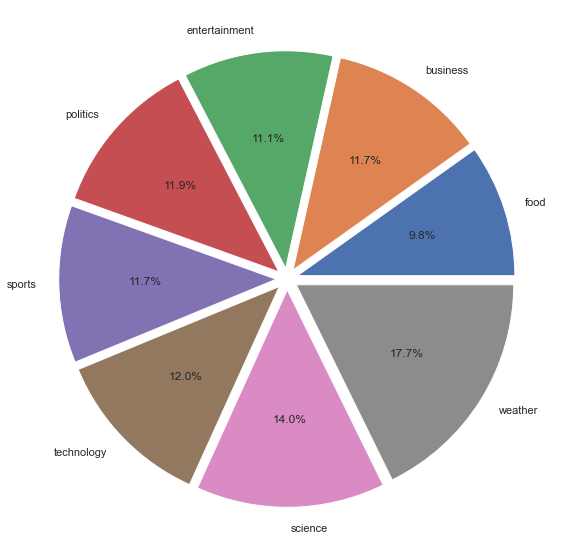

In [339]:
show_pie_chart(df)

### 5.11.2 WordCloud

entertainment:
C:\Users\efi13\source\last\png\entertainment.png


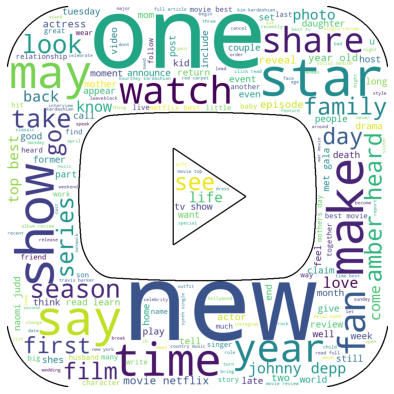

weather:
C:\Users\efi13\source\last\png\weather.png


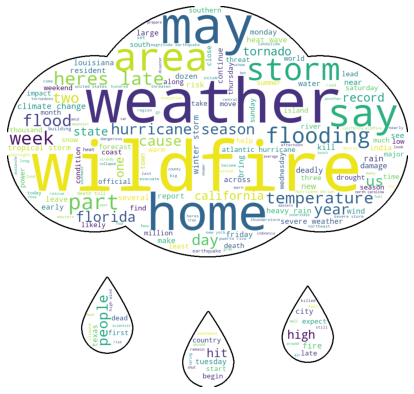

food:
C:\Users\efi13\source\last\png\food.png


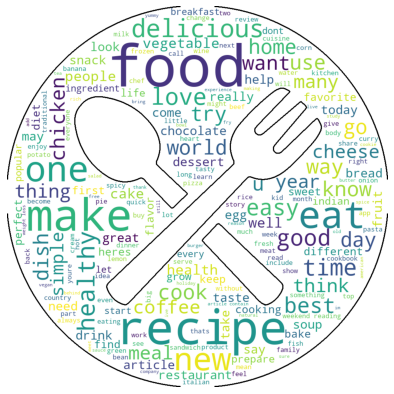

business:
C:\Users\efi13\source\last\png\business.png


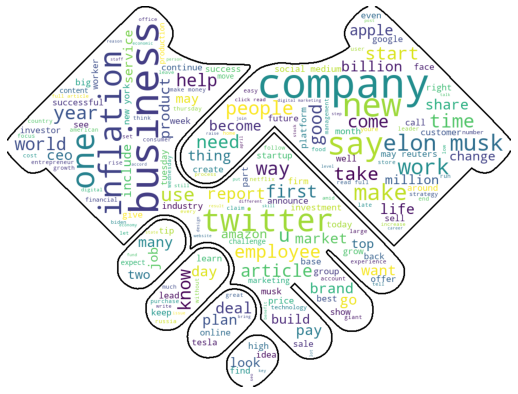

science:
C:\Users\efi13\source\last\png\science.png


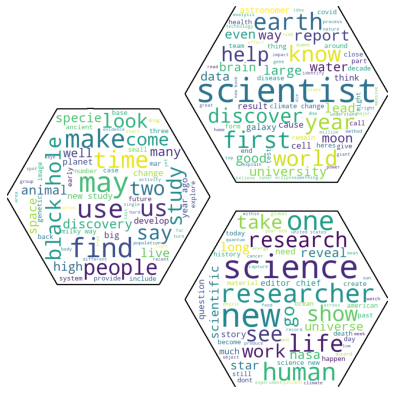

technology:
C:\Users\efi13\source\last\png\technology.png


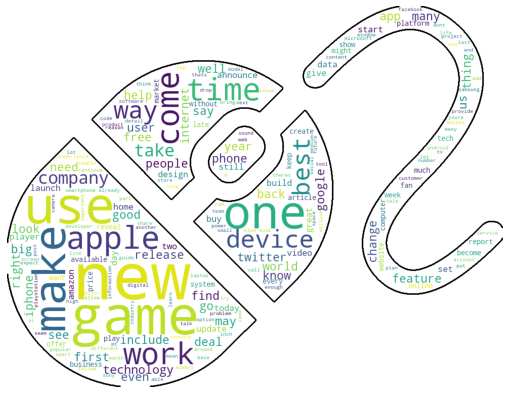

politics:
C:\Users\efi13\source\last\png\politics.png


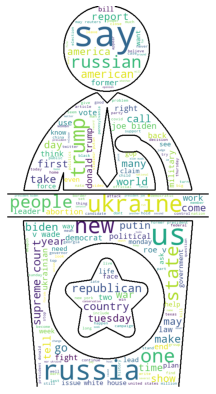

sports:
C:\Users\efi13\source\last\png\sports.png


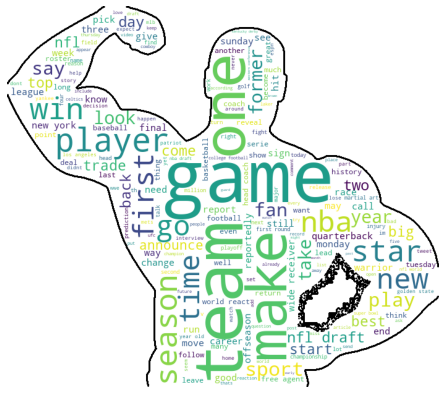

In [340]:
show_word_cloud(df)

### 5.11.3 Top 10 Words

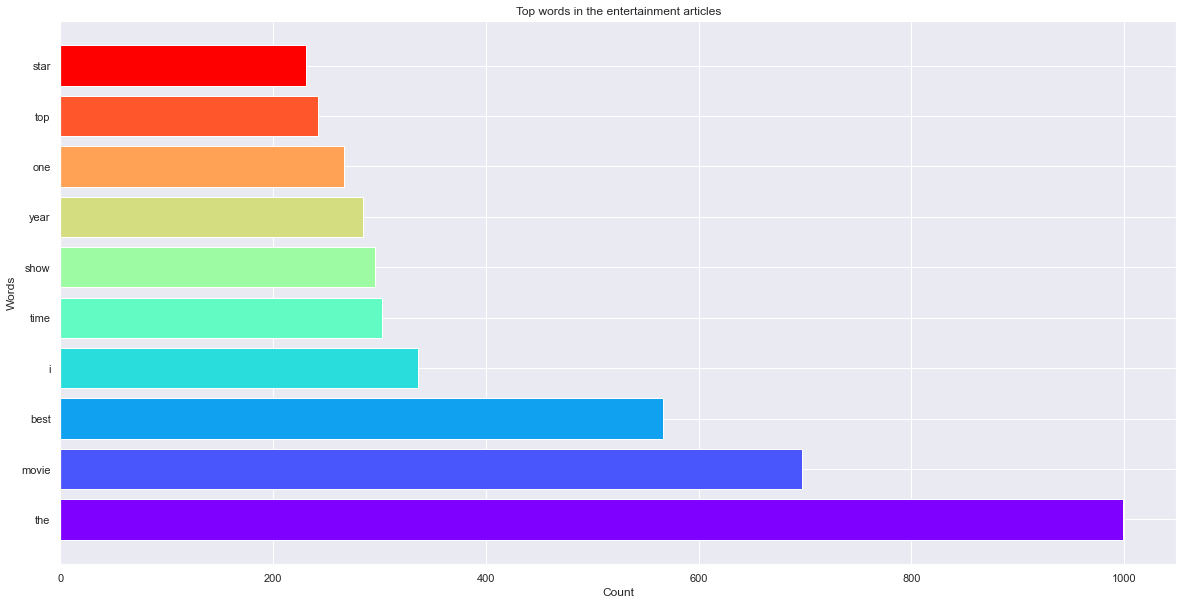

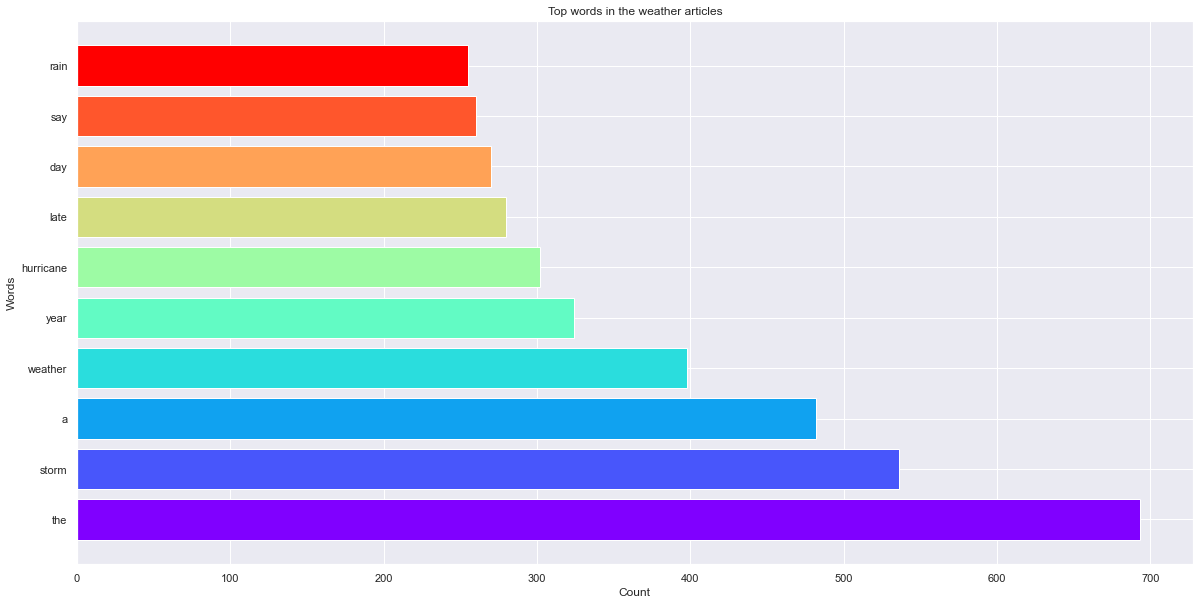

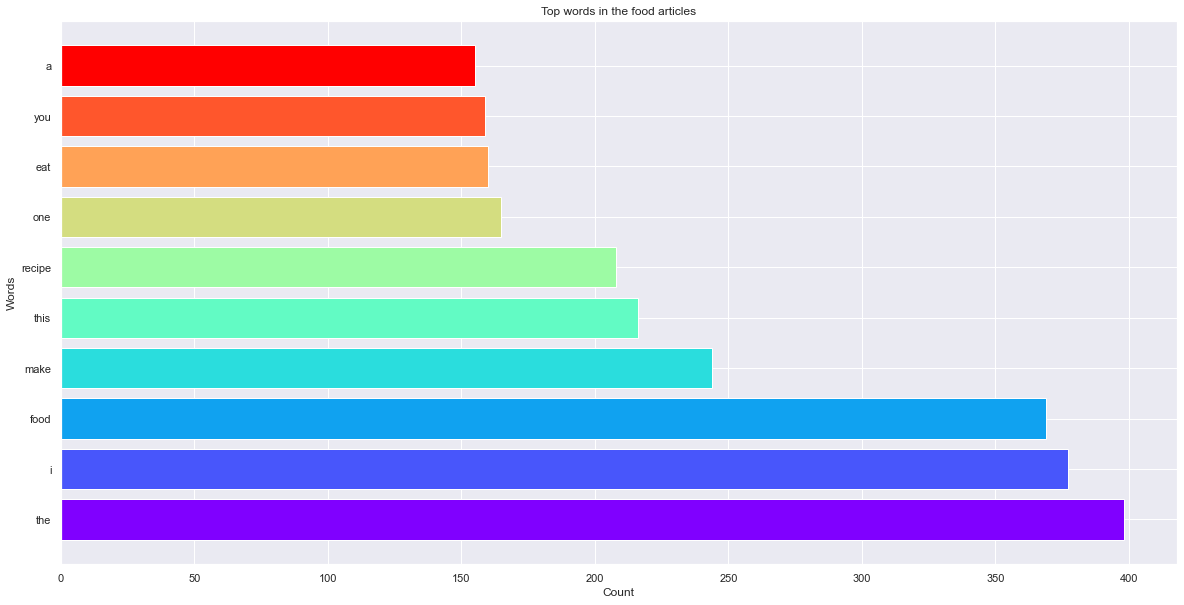

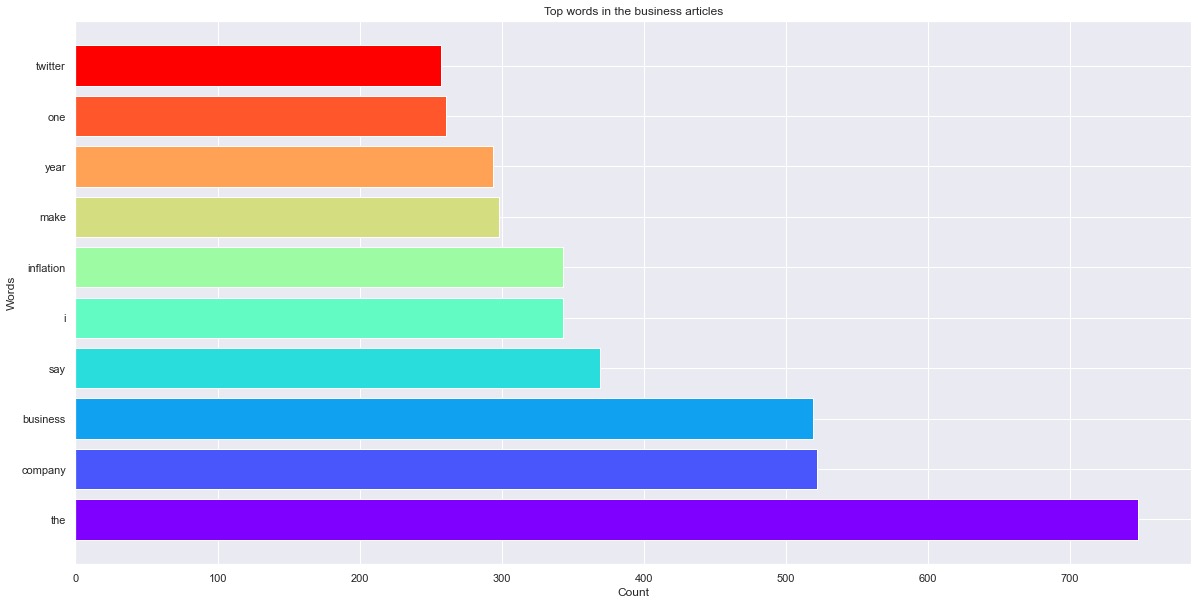

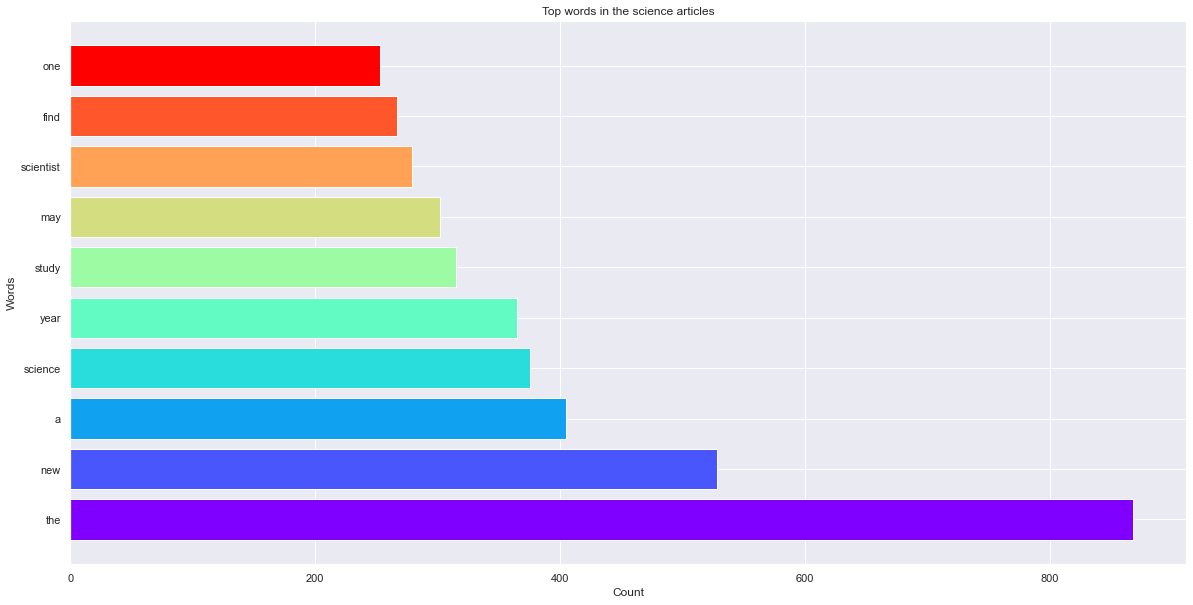

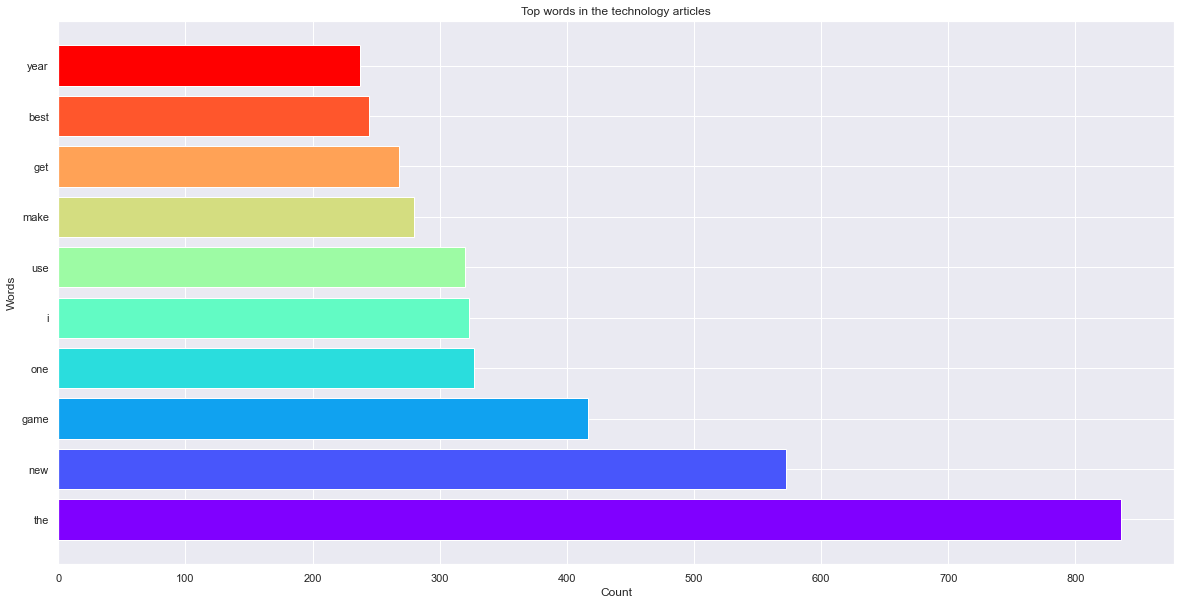

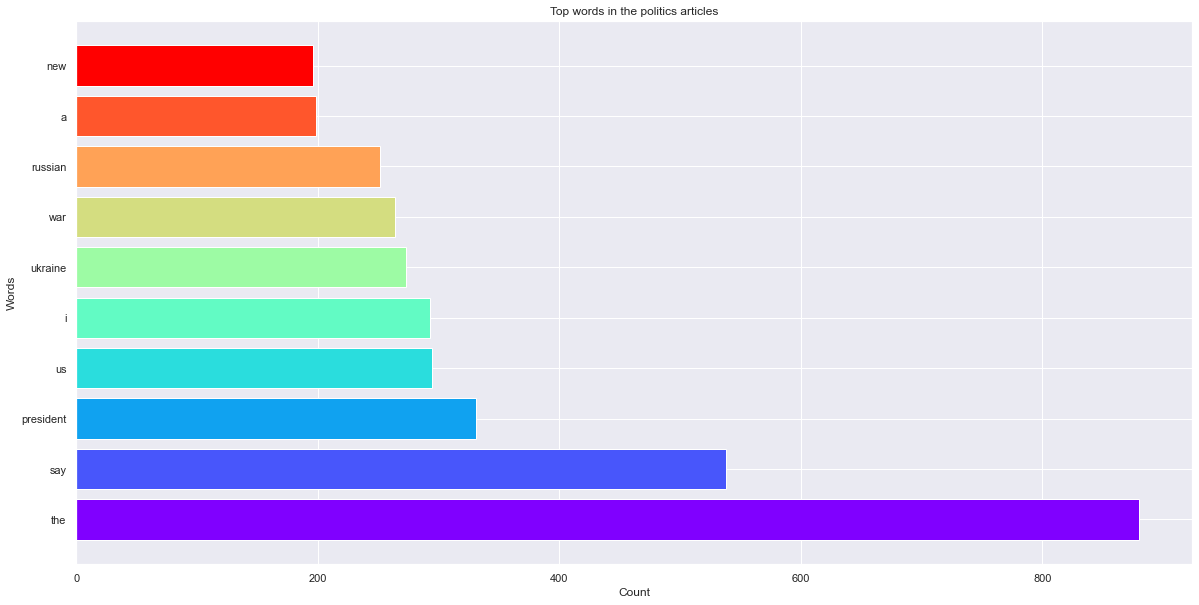

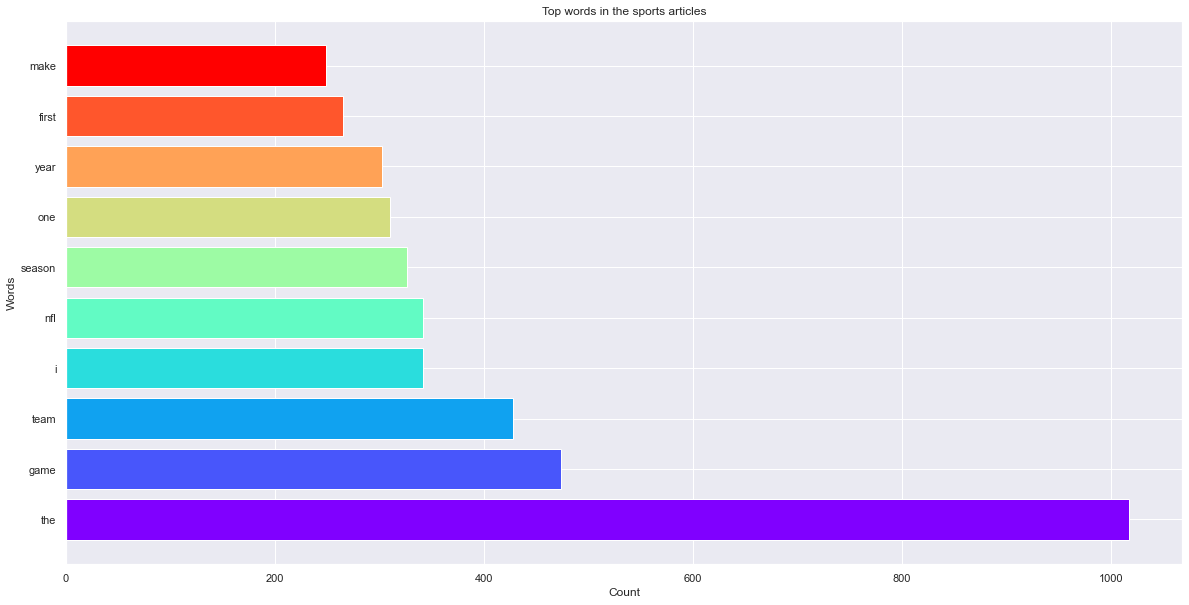

In [341]:
show_top_10_words(df)

### 5.11.4 Distribution of Words

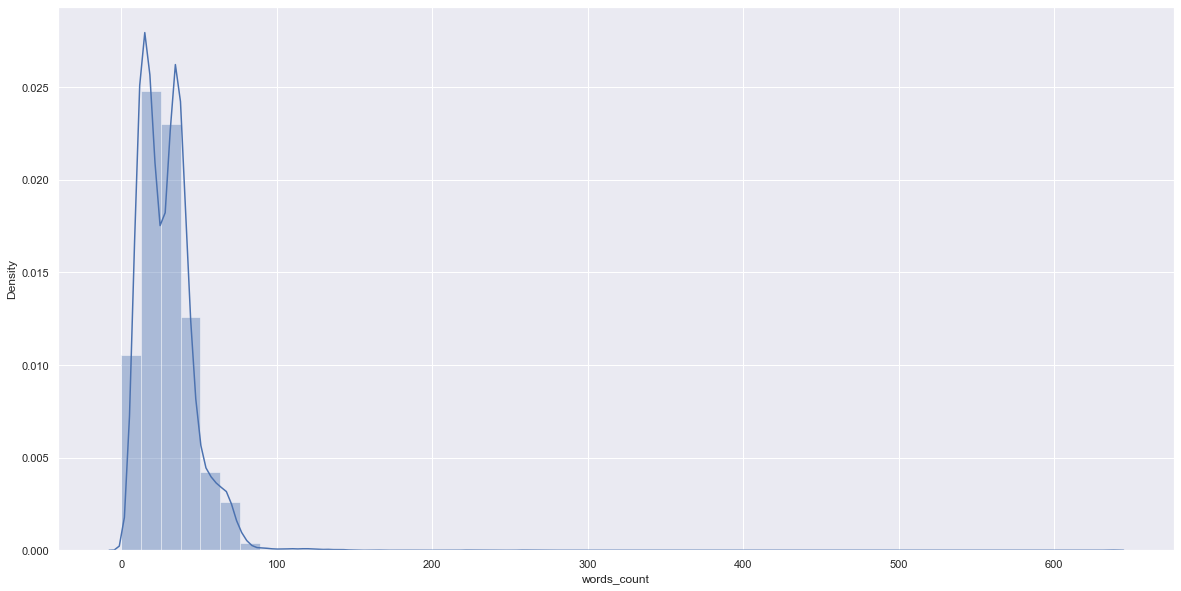

df size before remove 1000+ words: (14289, 3)
df size after remove 1000+ words: (14180, 3)


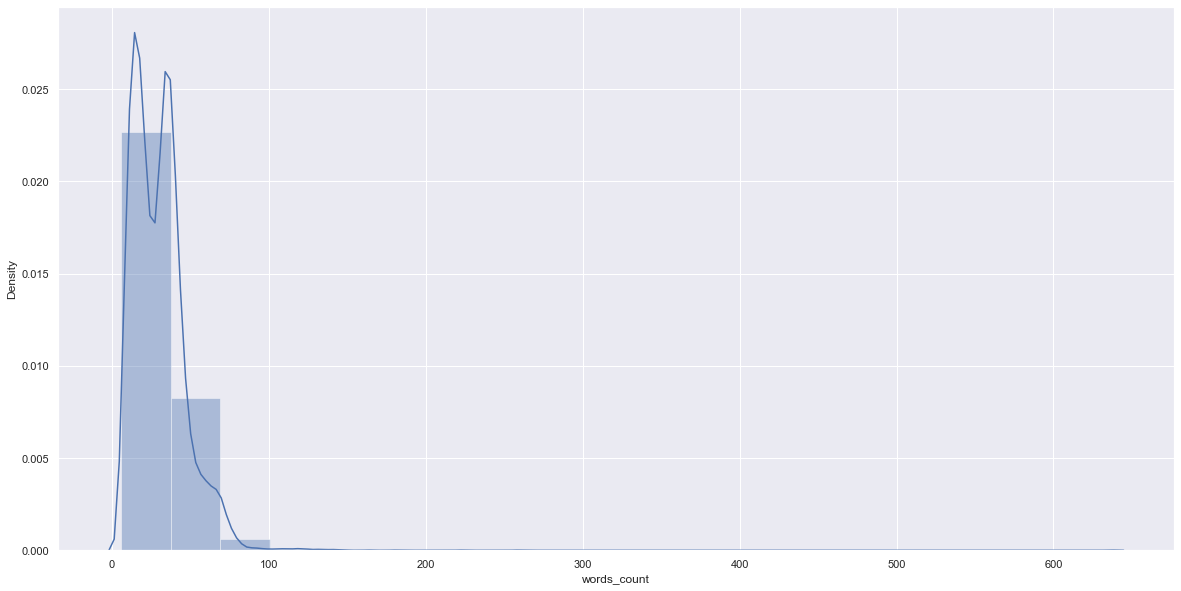

In [342]:
show_distribution_of_words(df)

### 5.11.5 Conclustion

## 5.12 Final EDA Conclustion

# 6.0 Vectorization and Machine Learning

In [351]:
df_ml = df.copy()
df_ml["category"].value_counts()
category_list = df_ml["category"].unique()

df_ml['category_id'] = df_ml['category'].factorize()[0]

df_ml

,category,merged_text,category_id
0,food,"[pounds, skippy peanut, butter, have, been rec...",0
1,food,"[impossible, foods, sausage, links, are, plant...",0
2,food,"[goodbye, chowhound internets, first, food, hu...",0
3,food,"[thank, you, mr, entenmann, nicest cake my lif...",0
4,food,"[how, home cooks are, supporting, ukrainians, ...",0
...,...,...,...
29895,weather,"[colorado, avalanches bury cars roadways backc...",7
29896,weather,"[alabama, gov, kay, ivey, views, ef, tornado d...",7
29897,weather,"[alabama, tornado victims funerals begin victi...",7
29898,weather,"[nasa captures, first, images intersecting, sh...",7


## 6.1 Cross Validation

### Pipeline
In order to make this flow easier to work with:  

`scikit-learn` package provides a `Pipeline` class that behaves like a compound classifier:

In [355]:
x = df_ml["merged_text"]
y = df_ml["category_id"]

print(df_ml["merged_text"].iloc[0][0])
print(type(df_ml["merged_text"].iloc[0][0]))
print(type(df_ml["merged_text"].iloc[0]))

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# text_clf = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
    
# model = text_clf.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# dis = plot_confusion_matrix(model, x_test, y_test, cmap="Blues", values_format=".3g")

pounds
<class 'str'>
<class 'list'>


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f"accuaracy score: {accuracy_score(y_test,y_pred)}")
print(f"precision_score: {precision_score(y_test,y_pred, average='micro')}")# TP / TP + FP
print(f"recall_score: {recall_score(y_test,y_pred, average='macro')}")# TP / TP + FN
print(f"f1_score: {f1_score(y_test,y_pred, average='weighted')}")# 2*P*R/(P+R)


# 7.0 Project Conclustion